<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# SNOW MONITORING WITH DATA CUBES IN NORTH TYROL - AUSTRIAN ALPS (Yearly analysis of snow cover)

Datacubes are powerful data structures that provide easy access to large amounts of data. Raw datacubes present this data indiscriminately to the user, meaning all data is available regardless of its quality. For instance, Sentinel-2 data is available as single tiles without any cloud masking applied. This approach ensures that no decisions about the data are made by the provider, giving users complete flexibility in how they work with the data.

However, this also places the responsibility on the user to process the data into formats suitable for analysis, such as by masking out clouds or mosaicking the data.

There are two primary methods for handling datacubes:
- Spatial aggregation

- Temporal aggregation

These two high-level concepts allow you to reduce terabytes of data to kilobytes of analysis-ready data. In this use case, we will explore how these aggregations can be performed on a datacube. Finally, we will demonstrate how these approaches can be scaled up to a continental level.

## Data Preparation

### Persistent Snow Area

The Persistent Snow Area (PSA) dataset provides an accessible introduction to working with datacubes, given its comparatively simple structure. Here’s a brief overview of the data:

- Multiple tiles in the same format as Sentinel-2 tiles
- One observation per year

Since there is only one observation per year, there is no need for temporal aggregation. Therefore, in this step, we will focus on spatially aggregating the data.

In [ ]:
from pathlib import Path
import tarfile
import shutil
import tempfile
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import YearLocator, DateFormatter 
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
    MimeType,
    parse_time,
)

config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]
config.sh_base_url = "https://creodias.sentinel-hub.com"

### Loading area of interest

In [ ]:
# Load in north tyrol
tyrol = gpd.read_file("../../data/raw/datacubes-snow-monitoring/input/north_tyrol.geojson")
# simplify geom to pass into payload 
tyrol_simple = tyrol.geometry.simplify(100)
geom = tyrol_simple[0]
geom_sh = Geometry(geom, CRS(3035))

### Defining used data

Here, we define the data sources we will use. Specifically, we are utilizing the Persistent Snow Area product from the HR-S&I dataset, as well as the digital elevation model and derived aspect values for Austria.

In [ ]:
psa = DataCollection.define_byoc("da7e0012-8c43-42db-a5dc-cfd606c8b2dd")
asp = DataCollection.define_byoc("fb426a12-f21d-4c9a-8848-eb4eca836bc9")

### Helper functions

These are two helper functions designed to make requests to the datacube and to handle the data downloaded from those requests.

In [ ]:
def get_request(
    input_data, 
    evalscript,
    geometry):
    """Specify Sentinel Hub Request

    Returns a Sentinel Hub Request based on some parameters.

    Params:
        input_data (SentinelHubRequest.input_data): an input data object
        evalscript (str): An evalscript to use in the request
        geometry (sentinelhub.Geometry): A sentinelhub.Geometry Object 
            representing the area of interest

    Returns:
        (sentinelhub.SentinelHubRequest) request with the passed in values set

    """
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF), 
            SentinelHubRequest.output_response("userdata", MimeType.JSON)],
        geometry=geometry,
        config=config,
        resolution=(100,100),
        data_folder=tempfile.gettempdir()
    )

def get_data(request, downloaded_data, file_path, **kwargs):
    """Utility function to handle the downloaded data
    
    This function does a few things: 
    
    1. It gets the json from the downloaded data and 
    opens it into a pandas dataframe. 
    2. It moves the data saved locally to a permanent location
    specified in `file_path`
    3. It adds metadata to the pandas dataframe

    Params:
        request (sentinelhub.SentinelHubRequest): A
            Sentinelhubrequest
        downloaded_data (dict): The downloaded data from
            the request
        file_path (Union[str, PathLike]): File path where
            the image file from the request data should be 
            saved to
        **kwargs will be saved into the pandas dataframe
            where the keys are the column names and the
            values the values in the rows.
    
    Returns:
        (pd.DataFrame) A pandas dataframe built from the
            output of userdata.json
    
    """
    stats = downloaded_data["userdata.json"]

    # Move tif from zipped folder to outputs, rename and delete folder
    output = Path(tempfile.gettempdir()) / request.get_filename_list()[0]
    with tarfile.open(output, "r:") as tar:
        tar.extract("default.tif") 
    Path(file_path).parent.mkdir(parents=True, exist_ok=True) 
    Path("default.tif").replace(file_path)
    shutil.rmtree(output.parent)

    # Make the dataframe
    df = pd.DataFrame(stats).T.reset_index(names="class")
    # Split the class into its keys
    df[["aspect", "elevation_below"]] = df["class"].str.split("_", n=1, expand=True)
    # Make all columns given as kwargs
    df[list(kwargs.keys())] = list(kwargs.values())
    return df

### Querying the Datacube

To go from large amounts of data to only what is necessary for the analysis, the datacube must be queried. First, let's consider the desired output for our upcoming analysis:

- A mosaicked image per year at the specified scale
- Spatial statistics:
  - The amount of persistent snow based on aspect class
  - The amount of persistent snow based on elevation

The initial step is to gather all the data needed for the analysis, which is one of the key advantages of using a datacube. A datacube allows access to multiple data sources simultaneously, making all necessary information available at each timestep.

For the snow monitoring use case, this means having access to aspect and elevation data along with snow monitoring data to derive spatial statistics.

Using Sentinel Hub, the way to query a datacube is by utilizing the Process API along with an evalscript. The evalscript enables extensive computations on the cloud, so only the data you need is downloaded to your local machine.

In [ ]:
with open("input/eval_psa.js", "r") as file:
    evalscript = file.read()

In [ ]:
years = range(2017, 2022)
out_paths = []
sh_requests = []
kwargs = []
for year in years:
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=psa,
            identifier="psa", 
            time_interval=(f"{year}-01-01", f"{year}-06-01"),
        ),
        SentinelHubRequest.input_data(
            data_collection=asp,
            identifier="asp"
        )
    ]
    out_paths.append(f"../../data/raw/datacubes-snow-monitoring/output/psa/psa_{year}.tif")
    request = get_request(input_data, evalscript, geom_sh)
    sh_requests.append(request)
    kwargs.append(dict(year=year))

In [ ]:
# create a list of requests
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)
dfs = [get_data(request, download, out_path, **kwarg) 
        for request, download, out_path, kwarg 
        in zip(sh_requests, downloaded_data, out_paths, kwargs)]
del downloaded_data

In [ ]:
all_data = pd.concat(dfs)
all_data["percent_snow_cover"] = all_data["sum"] / all_data["count"]
all_data["km2_snow"] = (0.1*0.1)*all_data["sum"]
all_data["km2_all"] = (0.1*0.1)*all_data["count"]
all_data.to_csv("../../data/raw/datacubes-snow-monitoring/output/psa_tyrol.csv")
all_data

## Data Analysis

Datacubes are powerful data structures that enable the handling of vast amounts of data across temporal and spatial domains in the cloud. From the requests conducted above, we receive data that can be immediately used for analysis.

The selected location for this analysis is North Tyrol, a region with high mountains and large populated valleys, making it an ideal area for conducting snow analysis. We will begin with a yearly analysis using the Persistent Snow Area (PSA).

### Impact of elevation on Persistent Snow Area 

An elevation range between 1500 and 4500 meters above sea level (masl) was selected, with elevation classes defined at 100-meter intervals.

In [ ]:
#Reading the CSV file of Persistent Snow Area and converting the "year" column to a datetime object 
df_PSA = pd.read_csv('../../data/raw/datacubes-snow-monitoring/output/psa_tyrol.csv', parse_dates=['year'])

In [ ]:
#Aggregate area data by year
PSA_year = pd.pivot_table(df_PSA,values = 'km2_snow', index = 'year', aggfunc=np.sum)
PSA_year

km2_snow
year                
2017-01-01     94.76
2018-01-01     87.26
2019-01-01    147.31
2020-01-01    147.34
2021-01-01    154.38

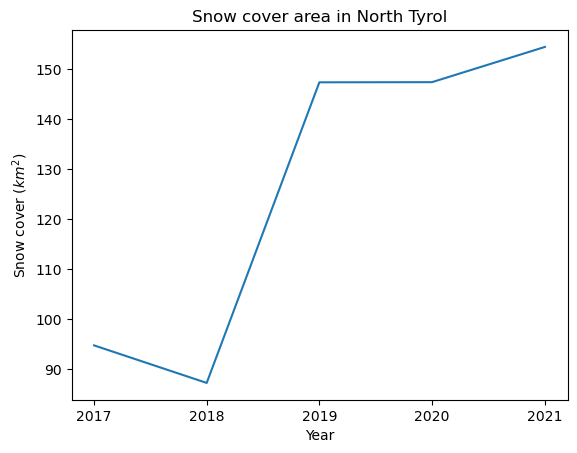

In [ ]:
#Time series of snow cover area
fig, ax = plt.subplots()

ax.plot(PSA_year.index, PSA_year.km2_snow);
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator());
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"));

ax.set(title = r'Snow cover area in North Tyrol', xlabel = 'Year', ylabel = 'Snow cover $(km^2)$');

The chart presents Persistent Snow Cover changes over the period from May 2017 to September 2021. Two years with minimum and maximum snow cover are observed: May 2017 - September 2017 and May 2021 - September 2021. This short time series doesn't allow us to analyze trends regarding snowpack evolution or gain insights from a climate change perspective. However, the dataset enables us to observe changes on a finer timescale by focusing on specific years and identifying years of interest. In the following steps, we will analyze the impact of topography on the persistent snow area.

In [ ]:
#Aggregate area by elevation and year
PSA_elevation = df_PSA.pivot_table('km2_snow', ['year'], 'elevation_below', aggfunc=sum)
PSA_elevation

elevation_below  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  \
year                                                                          
2017-01-01       0.00  0.00  0.00  0.00  0.04  0.30  0.14  0.07  0.27  0.32   
2018-01-01       0.00  0.05  0.01  0.00  0.02  0.01  0.00  0.00  0.17  0.38   
2019-01-01       0.00  0.00  0.00  0.03  0.00  0.01  0.01  0.01  0.07  0.11   
2020-01-01       0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.05   
2021-01-01       0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.07   

elevation_below  ...   3200   3300  3400  3500  3600  3700  3800  3900  4000  \
year             ...                                                           
2017-01-01       ...  18.92  12.56  6.07  2.00  0.33  0.18  0.04   0.0   0.0   
2018-01-01       ...  18.14  11.87  5.44  1.84  0.35  0.13  0.02   0.0   0.0   
2019-01-01       ...  29.70  17.70  7.19  2.36  0.35  0.17  0.01   0.0   0.0   
2020-01-01       ...  31.46  19.15  8.11  2.84  0.48  0.23  0.04   0.0   0.0   
2021-01-01       ...  32.71  19.97  8.02  2.78  0.49  0.22  0.03   0.0   0.0   

elevation_below  4500  
year                   
2017-01-01        0.0  
2018-01-01        0.0  
2019-01-01        0.0  
2020-01-01        0.0  
2021-01-01        0.0  

[5 rows x 27 columns]

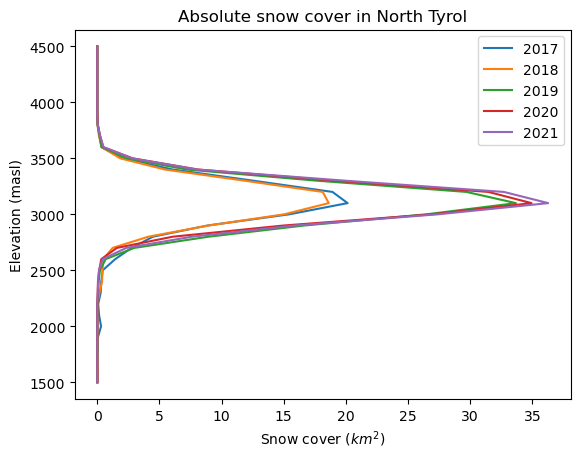

In [ ]:
#Absolute snow cover by year and elevation
elevation_below = list(map(float, PSA_elevation.columns))
for row in PSA_elevation.iterrows():
    plt.plot(row[1].values, elevation_below)

plt.title('Absolute snow cover in North Tyrol')
plt.xlabel(r"Snow cover $(km^2)$")
plt.ylabel(r"Elevation (masl)")

plt.legend(['2017','2018', '2019', '2020', '2021'])    
plt.show()

The distribution of PSA primarily falls within the elevation range of 2700 to 3500 masl. Periods of minimum and maximum PSA are also captured in the chart. The largest absolute area of PSA is found at approximately 3300 masl.

In [ ]:
#Aggregate the sum and count columns to calculate relative snow cover
PSA_elevation_sum = df_PSA.pivot_table(values = ["sum"], index = ['year'], columns = ['elevation_below'], aggfunc=sum)
PSA_elevation_count = df_PSA.pivot_table(values = ["count"], index = ['year'], columns = ['elevation_below'], aggfunc=sum)

#Calculate relative snow cover
PSA_elevation_percent_cover = (PSA_elevation_sum["sum"]/PSA_elevation_count["count"]).fillna(0)

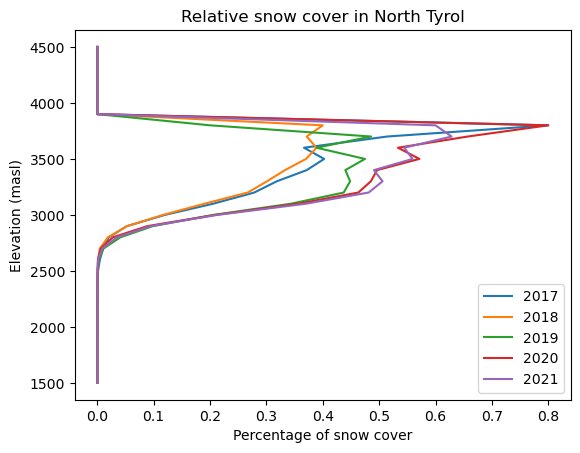

In [ ]:
#Relative snow cover by year and elevation

elevation_below = list(map(float, PSA_elevation_percent_cover.columns))
for row in PSA_elevation_percent_cover.iterrows():
    #plt.plot(row[1].values, elevation_below, label=row[1].name)
    plt.plot(row[1].values, elevation_below)

plt.title('Relative snow cover in North Tyrol')
plt.xlabel(r"Percentage of snow cover")
plt.ylabel(r"Elevation (masl)")

plt.legend(['2017','2018', '2019', '2020', '2021'])      
plt.show()

The chart also shows the persistent snow cover relative to the total area in the elevation interval. A wider elevation range of persistent snow cover is observed, with higher elevations tending to have more persistent snow cover. However, in absolute terms, the snow cover at very high elevations (i.e., above 3500 masl) is not significant because few peaks reach those altitudes.

### Impact of the aspect on Persistent Snow Area 

For the integration of aspect in the analysis, the main eight cardinal directions were considered.

In [ ]:
#Aggregate area by aspect and year
PSA_aspect = df_PSA.pivot_table('km2_snow', ['year'], 'aspect', aggfunc=sum)
PSA_aspect

aspect        0      45     90     135   180   225    270    315
year                                                            
2017-01-01  23.49  18.39  11.32   6.49  4.92  4.35   9.46  16.34
2018-01-01  21.79  16.44  10.72   6.47  4.81  4.08   8.51  14.44
2019-01-01  36.38  28.42  17.08  10.50  7.20  6.78  15.23  25.72
2020-01-01  39.50  28.39  16.48   9.06  6.07  5.52  14.32  28.00
2021-01-01  38.81  29.54  17.75  10.49  7.00  6.80  16.12  27.87

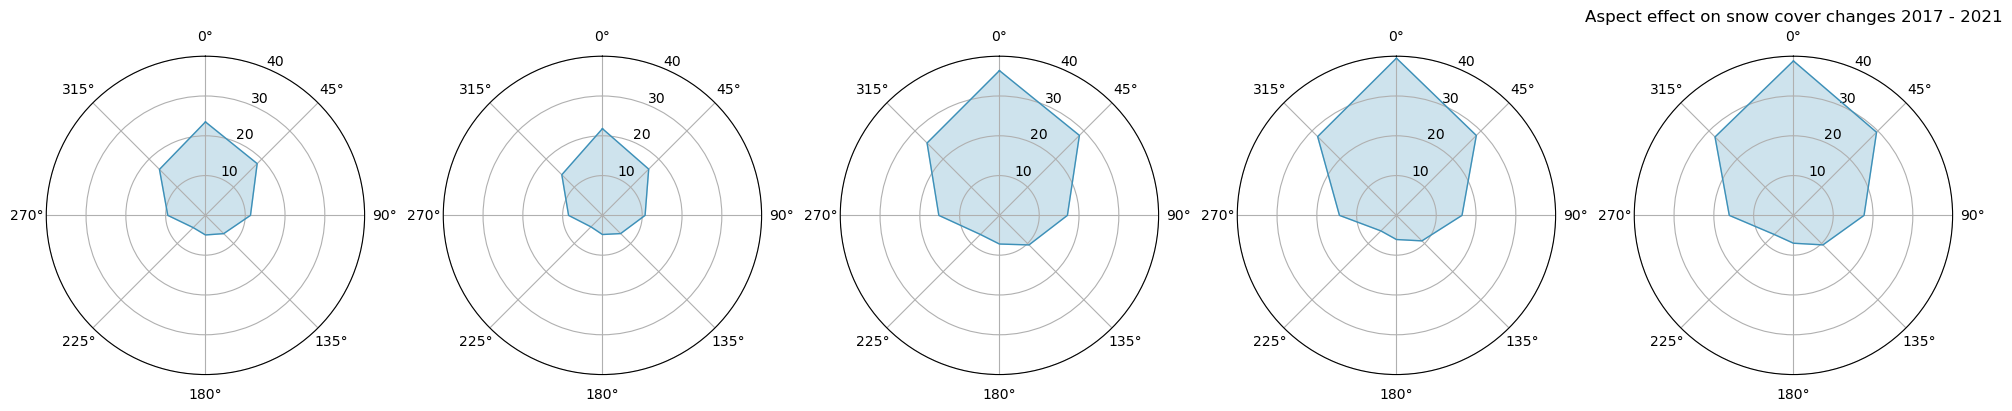

In [ ]:
# Define aspect categories
categories=list(PSA_aspect)[0:]

N = len(categories)

# create angle by dividing the plot / number of variable
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=len(PSA_aspect), figsize=(20, 12), 
              subplot_kw=dict(polar=True), dpi = 100)

plt.title('Aspect effect on snow cover changes 2017 - 2021')

fig.tight_layout()

for i in range(len(PSA_aspect)):
    values =  PSA_aspect.loc[PSA_aspect.index[i]].values.flatten().tolist()
    values += values[:1]

     # Draw the outline of the data.
    ax[i].plot(angles, values, color='#3D90B8', linewidth=1, 
          )
    # Fill in the color polygons  
    ax[i].fill(angles, values, color='#3D90B8', alpha=0.25) 

    # Fix axis to go in the right order and start at 12 o'clock.
    ax[i].set_theta_offset(np.pi / 2)
    ax[i].set_theta_direction(-1)

    #set the limits of y axis
    ax[i].set_ylim(0,40)
    ax[i].set_yticks([10,20,30,40])

The aspect patterns are consistent across the years analyzed, with a notable amount of Persistent Snow Area on north-facing slopes. Conversely, there is significantly less Persistent Snow Area on south-facing slopes.

In [ ]:
#Comparing periods of minimum and maximum extent (2017 - 2018) and (2020 - 2021)
PSA_aspect_2018_2021 = PSA_aspect.iloc[[1, 4]]
PSA_aspect_2018_2021 

aspect        0      45     90     135   180   225    270    315
year                                                            
2018-01-01  21.79  16.44  10.72   6.47  4.81  4.08   8.51  14.44
2021-01-01  38.81  29.54  17.75  10.49  7.00  6.80  16.12  27.87

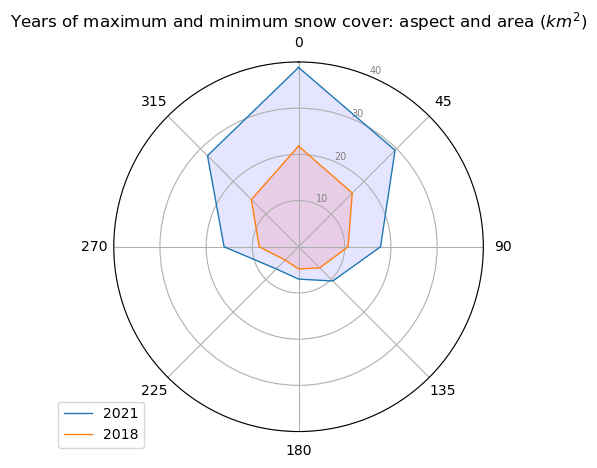

In [ ]:
# Define orientation categories
categories=list(PSA_aspect_2018_2021 )[0:]

N = len(categories)

# Create angle by dividing the plot / number of variable
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the polar plot
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)            

#Set the limits of y axis
ax.set_rlabel_position(22.5)
plt.yticks([10,20,30,40], ["10","20","30", "40"], color="grey", size=7)
ax.set_ylim(0,40)

# Add plots
#Period 2020-2021
values=PSA_aspect_2018_2021.loc[PSA_aspect_2018_2021.index[1]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2021")
ax.fill(angles, values, 'b', alpha=0.1) 

# Period 2017 - 2018
values=PSA_aspect_2018_2021.loc[PSA_aspect_2018_2021.index[0]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2018")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.title(r'Years of maximum and minimum snow cover: aspect and area $(km^2)$')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1));
 

The distribution pattern of snow on the slopes is quite similar during periods of both minimum and maximum persistent snow area. The PSA from May 2021 to September 2021 is more than double the extent of PSA from May 2018 to September 2018.

## Summary

- Extending this dataset is crucial as it will continue to gain value over the years.

- We conducted an aggregation of vast amounts of data using datacubes to analyze the annual snow cover in North Tyrol.

- The PSA dataset provided insights into identifying the years with maximum and minimum snow cover over the period of analysis.

- The relative PSA indicates that the maximum snow cover is found at around 3300 masl, while the absolute snow cover shows that higher elevations are more likely to have more snow cover.

- North-facing slopes have significantly more snow cover compared to south-facing slopes.

- We obtained a broad perspective by identifying the years with minimum and maximum snow cover and understanding the general impact of topography. However, what is happening at a finer timescale?